<a href="https://colab.research.google.com/github/vaibhavsundharam/Super-Sampling/blob/main/Auto_Encoders_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we implement Deep Denoiseing SRCNN, this model is a modefied version of the network presented in the paper "Image Restoration Using Convolutional Auto-encoders with Symmetric Skip Connections" [[1](https://arxiv.org/abs/1606.08921)] by Xiao-Jiao Mao, Chunhua Shen, Yu-Bin Yang


#General Initializations

In [ ]:
import torch
import sys
import os
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import PIL
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
import glob
import random
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/My Drive/Computer Vision/"
sys.path.append(customized_path_to_project)

#Data Preprocessing (data loaders and data augmentation) <br>


Storing image locations in a CSV file for further processing 

In [ ]:
import itertools
# Dataset Location
dataset_location = customized_path_to_project + "Data/Cars/data/cars_train"
csv_file_name = dataset_location.split("/")[-1]+ ".csv"
grabbed = [glob.glob(dataset_location + f) for f in ['/*.jpg', '/*.jpeg', '/*.JPEG', '/*.png', '/*.bmp', '/*.tiff' ]]
merged = list(itertools.chain(*grabbed))
with open(csv_file_name, "w") as out:
    for image_loc in merged:
      out.write(image_loc + "\n")    

#Datasets and Image Augmentations

In [ ]:
# custom class to explore dataset
class Imagenet_dataset(Dataset):
  def __init__(self, csv_location, scale, transform=None):
    self.transform = transform
    self.image_csv = pd.read_csv(csv_location, header=None)
    self.scale = scale       

  def __len__(self):  # returns the length of the data set
     return len(self.image_csv)

  
  def downsample_image(self, image):
    scale_percent = 100/self.scale
    w = int(image.shape[1] * (scale_percent / 100))
    h = int(image.shape[0] * (scale_percent / 100))
    dimention = (w, h)  
    resize_image = cv2.resize(image, dimention, interpolation=cv2.cv2.INTER_AREA)
    
    # scale back to original size
    w = int(resize_image.shape[1] * (100 / scale_percent))
    h = int(resize_image.shape[0] * (100 / scale_percent))
    dimention = (w, h)
    low_res_image = cv2.resize(resize_image, dimention, interpolation=cv2.INTER_AREA)
    return low_res_image

  def __getitem__(self, idx):  

    images = dict()

    image_location = str(self.image_csv.iloc[idx, 0])
    image = cv2.imread(image_location)
    image = cv2.resize(image, (224,224) , interpolation=cv2.INTER_AREA)
       
    images["HR"] = image  #cv2.imread(image_location)
    images["LR"] = self.downsample_image(image) #self.downsample_image(cv2.imread(image_location))
        
    if self.transform == None:
      images["HR"] = images["HR"].transpose(2, 0, 1).astype(np.float32)
      images["LR"] = images["LR"].transpose(2, 0, 1).astype(np.float32)
      return images 

    else:
      images = self.transform(images)      
      return images       

In [ ]:
class Random_Crop(object):
  '''
  In this class an input low resolutiona and high resolution image
  is cropped randomly
  '''
  def __init__(self, scale, patch_size):
    self.scale = scale
    self.patch_size = patch_size

  def __call__(self, sample):
    HR, LR = sample["HR"], sample["LR"] 
    height, width = LR.shape[:2]    

    x = random.randrange(0, width - self.patch_size +1)    
    y = random.randrange(0, height - self.patch_size +1)    
    
    LR_patch = LR[y : y + self.patch_size, x : x + self.patch_size]
    HR_patch = HR[y : y + self.patch_size, x : x + self.patch_size]    
    return {"HR": HR_patch, "LR": LR_patch}

In [ ]:
class Data_Augmentation(object):
  '''
  This class implements random horizontal flipping,
  random virticle flipping and random rotation to an 
  imput image
  '''
  def __call__(self, sample):
    HR, LR = sample["HR"], sample["LR"]
    horizontal_flip = random.randrange(0,2)
    vertical_flip = random.randrange(0,2)
    rotation = random.randrange(0,2)

    if horizontal_flip == 1:      
      LR = np.fliplr(LR)      
      HR = np.fliplr(HR)       

    if vertical_flip ==1:       
      LR = np.flipud(LR)      
      HR = np.flipud(HR)       

    if rotation == 1:
      LR = LR.transpose(1, 0, 2)
      HR = HR.transpose(1, 0, 2)  

    return { "HR" : HR, "LR" : LR}

In [ ]:
class Normalize(object):
  '''
  Normalizing and centering input images and converting it to tensor
  '''
  def __init__(self):
    self.transform = transforms.Compose([
                              transforms.ToPILImage(),                            
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                std = [0.229, 0.224, 0.225]) 
                              ])
  def __call__(self, sample, esp=1e-6):
    HR, LR = sample["HR"], sample["LR"]
    HR = self.transform(HR)
    LR = self.transform(LR)
    return { "HR" : HR, "LR" : LR}

# Data exploration<br>
We will be using a modified version of the imagenet dataset that consist of car images. Here we plot some samples from the training data to visualize the data

In [ ]:
csvfile_hr = pd.read_csv("/content/cars_train.csv")
random_samples = random.sample(range(len(csvfile_hr)), k=5) # generating 5 random samples 
images = [csvfile_hr.iloc[i, 0] for i in random_samples]

In [ ]:
def plot(images):
  fig, axs = plt.subplots(1, len(images), figsize =(20,20))
  for i in range(len(images)):
    axs[i].imshow(plt.imread(images[i]))
    axs[i].set_title(f"High resolution image {i+1}")     
  plt.show()

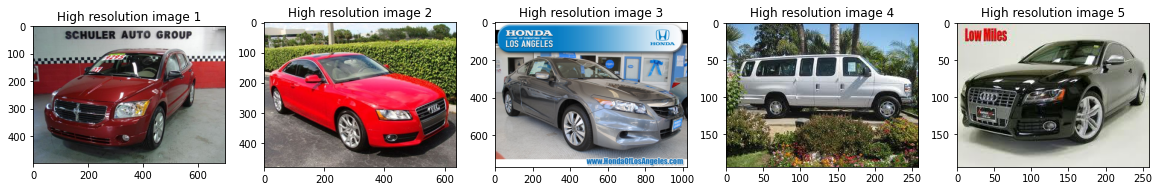

In [ ]:
plot(images)

# Designing Auto-Encoders<br>
Following image depicts the architecture of the encoder and decoder used for super-resolution task<br><br>
<img src="https://drive.google.com/uc?export=view&id=1VCFN_zTyVP8EpY2ux2TW4LgxphTnWpLP" width=500><br>

In [ ]:
class conv_block(nn.Module):
  '''
  A conv block is a sequantial model with convolution layer followed by ReLU() 
  activation
  '''
  def __init__(self, in_channels, out_channels, kernel_size=3, activation=nn.ReLU(), stride=1):
    super(conv_block, self).__init__()
    layers = list()
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=(kernel_size//2)))        

    if activation is not None:
      layers.append(activation)

    self.Conv_Block = nn.Sequential(*layers)

  def forward(self, x):
    return self.Conv_Block(x)

In [ ]:
class SR_Autoencoder(nn.Module):
  def __init__(self, image_features=3, kernel_size=3):
    super(SR_Autoencoder, self).__init__()  
    #### encoder ####
    self.conv_1 = conv_block(in_channels=image_features, out_channels=64)
    self.conv_2 = conv_block(in_channels=64, out_channels=64) # skip connection
    self.maxpool_1 = nn.MaxPool2d(kernel_size = (2,2))
    self.conv_3 = conv_block(in_channels=64, out_channels=128)
    self.conv_4 = conv_block(in_channels=128, out_channels=128) # skip connection 
    self.maxpool_2 = nn.MaxPool2d(kernel_size = (2,2))
    self.conv_5 = conv_block(in_channels=128, out_channels=256)
    ##################

    #### decoder ####
    self.upsampling_1 = nn.Upsample(scale_factor=2)
    self.conv_6 = conv_block(in_channels=256, out_channels=128)
    self.conv_7 = conv_block(in_channels=128, out_channels=128)
    self.upsampling_2 = nn.Upsample(scale_factor=2)
    self.conv_8 = conv_block(in_channels=128, out_channels=64)
    self.conv_9 = conv_block(in_channels=64, out_channels=64)
    self.conv_10 = conv_block(in_channels=64, out_channels=3)
    self.last = nn.Tanh()
    ##################    

  def forward(self, x):
    #### encoder ####
    x = self.conv_1(x)
    x = self.conv_2(x)
    skip_conv_2 = x
    x = self.maxpool_1(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    skip_conv_4 = x
    x = self.maxpool_2(x)
    x = self.conv_5(x)
    ##################

    #### decoder ####
    x = self.upsampling_1(x)    
    x = self.conv_6(x)
    x = self.conv_7(x)
    x = torch.add(x, skip_conv_4)
    x = self.upsampling_2(x)
    x = self.conv_8(x)
    x = self.conv_9(x)
    x = torch.add(x, skip_conv_2)
    x = self.conv_10(x)
    ##################
    return self.last(x)

In [ ]:
class TV_Loss(nn.Module): 
  '''Regularization'''
  def __init__(self, tv_loss_weight=1):
    super(TV_Loss, self).__init__()
    self.tv_loss_weight = tv_loss_weight

  def forward(self, sample):
    batch_size = sample.size()[0]
    height = sample.size()[2]
    width = sample.size()[3]
    count_h = self.tensor_size( sample[:, :, 1:, :])
    count_w = self.tensor_size( sample[:, :, :, 1:])
    h_tv = torch.sum(torch.pow(( sample[:, :, 1:, :] -  sample[:, :, :height - 1, :]), 2))
    w_tv = torch.sum(torch.pow(( sample[:, :, :, 1:] -  sample[:, :, :, :width - 1]), 2))
        
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  @staticmethod
  def tensor_size(x):
    return x.size()[1] * x.size()[2] * x.size()[3]

# Model training 

In [ ]:
def image_show(lr_images, fake_hr_images, real_hr_images):
  transform = transforms.Compose([transforms.Normalize(mean = [-2.118, -2.036, -1.804], # Equivalent to un-normalizing ImageNet (for correct visualization)
                                                       std = [4.367, 4.464, 4.444]),
                                            transforms.ToPILImage()])
  figure,axs =  plt.subplots(5, 3, figsize =(20,20))
  sample = random.sample(range(0, lr_images.shape[0] -1), 5) # randomly selecting 5 images in the batch    

  for idx, img in enumerate(sample):
    lr_image =transform(lr_images[img])
    fake_hr_image = transform(fake_hr_images[img])
    real_hr_image = transform(real_hr_images[img])
    axs[idx][0].imshow(lr_image)
    axs[idx][0].set_title("Low resolution image")
    axs[idx][1].imshow(fake_hr_image)
    axs[idx][1].set_title("High resolution fake/generated image")
    axs[idx][2].imshow(real_hr_image)
    axs[idx][2].set_title("High resolution real/target image")
  plt.show()

In [ ]:
def PSNR(y_real, y_fake):
  assert y_real.shape == y_fake.shape, "Unable to compute PSNR. Input shapes not same." \
                                         " y_true shape = %s, y_pred shape = %s" % (str(y_real.shape),
                                                                                   str(y_fake.shape))  
  mse = torch.mean((y_real - y_fake) ** 2)
  if mse == 0:
      return "Same Image"
  return 10 * torch.log10(1. / mse)   

In [ ]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

# Splittening dataset into training and test set
scale = 4
patch_size = 224 # make sure that the patch size is not larger than the smallest image in the dataset
transform = transforms.Compose([Random_Crop(scale=scale, patch_size=patch_size),                                
                                Normalize()])
dataset =  Imagenet_dataset(csv_location="/content/cars_train.csv", scale=scale, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.90),int(len(dataset)*0.10) + 1]) # split 90:10

In [ ]:
def train(dataset, epochs, batch_size=16, num_workers=8, lr=1e-3, scale=4, vgg_rescale_coeff=1, mse_loss_coeff=1e-3, tv_loss_coeff=1e-3, cont_autoencoder_training = False):
 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  writer = SummaryWriter(log_dir=output_dir+"autoencoder_runs")  
  
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  print(f"Total number of training example: {len(dataset)}\n")

  ### model initialization ###
  autoencoder = SR_Autoencoder().to(device)  
  optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
  ############################
  
  ### other initializations ###
  total_step = len(loader)
  log_step = 200
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
  max_psnr = None
  #############################

  ### initializing VGG model###      
  vgg19 = models.vgg19(pretrained=True)
  modified_vgg19 =  list(vgg19.features.children())[:37]
  vgg19 = nn.Sequential(*modified_vgg19).to(device)
  vgg19.eval()
  #############################
  
  ### initializing losses ###     
  mse_loss = nn.MSELoss().to(device)   
  L1_loss =  nn.L1Loss().to(device)      
  tv_loss = TV_Loss().to(device)  
  ############################  

  if cont_autoencoder_training == True:
      autoencoder.load_state_dict(torch.load(output_dir + "weights_autoencoder/pre-trained weights/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5"))      
      sys.stdout.write("Loading weights for autoencode\n")

  print("------Training Autoencoder------")
  for epoch in range(epochs):    
    autoencoder.train()
    mean_mse_loss = 0.0
    mean_content_loss = 0.0
    mean_total_loss = 0.0
    mean_psnr= 0.0
    for itr, data in enumerate(loader):      

      hr_image = Variable(data["HR"].float().to(device)) # high resolution real images
      lr_image = Variable(data["LR"].float().to(device)) # low resolution rescaled images

      #### training ###
      autoencoder.zero_grad()

      autoencoder_output = autoencoder(lr_image)      
      Mse_loss = mse_loss_coeff*mse_loss(autoencoder_output, hr_image)
      Content_loss  = vgg_rescale_coeff*L1_loss(vgg19(autoencoder_output), vgg19(hr_image))
      loss = Mse_loss + Content_loss + tv_loss_coeff*tv_loss(autoencoder_output)
      mean_mse_loss += Mse_loss.item()
      mean_content_loss += Content_loss.item()    
      mean_total_loss += loss.item()

      loss.backward()
      optimizer.step()  

      psnr = PSNR(hr_image.cpu().data, autoencoder_output.cpu().data)   
      mean_psnr += psnr
      ################
      ### training logs ###      
      if itr % log_step == 0:
        sys.stdout.write(f"Printing running logs-Epoch: {epoch+1} Step: {itr}/{total_step}\n")
        # print current loss          
        sys.stdout.write(f"Autoencoder losses-> (mse-loss/content-loss/total-loss(with tv regularization)): {Mse_loss.item()}, {Content_loss.item()}, {loss.item()}\n")          
        sys.stdout.write(f"PSNR: {psnr}")
        image_show(lr_image.cpu().data, autoencoder_output.cpu().data, hr_image.cpu().data)
      clear_output(wait=True)
    sys.stdout.write(f"Epoch {epoch+1} Lossses\nAutoencoder (mse-loss/content-loss/total-loss(with tv regularization)): {mean_mse_loss/total_step}, {mean_content_loss/total_step}, {mean_total_loss/total_step}\n\n")    
    sys.stdout.write(f"PSNR : {mean_psnr/total_step}\n")

    writer.add_scalar("Autoencoder/mse_loss", mean_mse_loss/total_step, epoch)
    writer.add_scalar("Autoencoder/content_loss", mean_content_loss/total_step, epoch)
    writer.add_scalar("Autoencoder/total_loss", mean_total_loss/total_step, epoch)    
    writer.add_scalar("SRGAN PSNR", mean_psnr/total_step, epoch)

    scheduler.step(mean_psnr/total_step)

    if max_psnr == None:
      max_psnr =  mean_psnr/total_step

    if mean_psnr/total_step >= max_psnr:
      sys.stdout.write("\nUpdating best epoch\n")
      max_psnr = mean_psnr/total_step
      torch.save(autoencoder.state_dict(), os.path.join(output_dir, "weights_autoencoder", f"{epoch+1}_best_autoencoder.pth"))

    if epoch % 1 == 0:
      # Checkpoint  autoencoder
      torch.save(autoencoder.state_dict(), os.path.join(output_dir, "weights_autoencoder", f"{epoch+1}_autoencoder.pth"))
  return autoencoder     

In [ ]:
model = train(dataset=train_set, epochs=1000, batch_size=32, num_workers=8, lr=1e-3, scale=4, vgg_rescale_coeff=0.006, mse_loss_coeff=1, tv_loss_coeff=1e-3, cont_autoencoder_training = False)

Printing running logs-Epoch: 2 Step: 200/230
Autoencoder losses-> (mse-loss/content-loss/total-loss(with tv regularization)): 1.0613991022109985, 0.002329497132450342, 1.0637586116790771
PSNR: -0.2587871253490448